<a href="https://colab.research.google.com/github/sgulyano/mat202/blob/main/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAT-202 Lab 6: Wavelet

CMKL University

By Sarun Gulyanon


### Goal

Introduce students to the fundamental concepts of wavelet transforms and their applications in image denoising and compression.

### Outline

In this lab, students will explore the Haar wavelet transform, understand how it decomposes an image into different frequency components, and apply it for basic denoising and compression tasks.

----

## 1. Haar Wavelet

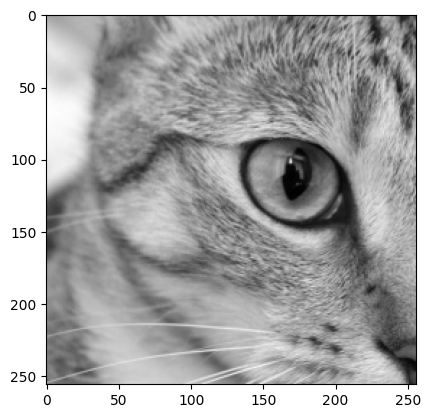

In [43]:
import cv2
import numpy as np
from skimage import data
import matplotlib.pyplot as plt
%matplotlib inline


#@title Select Image {run: 'auto'}
image_name = 'cat' #@param ['astronaut', 'camera', 'cat', 'coffee', 'checkerboard', 'page']

img = getattr(data, image_name)()
if img.ndim > 2:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Truncate image to the largest 2^n x 2^m region
h, w = img.shape[:2]

# Find the largest power of 2 less than or equal to each dimension
new_h = 1 << int(np.floor(np.log2(h)))
new_w = 1 << int(np.floor(np.log2(w)))

# Crop from the top-left corner (can center-crop if preferred)
img = img[:new_h, :new_w] / 255.

plt.imshow(img, cmap='gray')
plt.show()

In [44]:
img.shape

(256, 256)

We write functions below for the 2D Haar Wavelet Transformation and inverse Transformation.
- `haar_wavelet()` function recursively decomposes an image into approximation and detail components, capturing low-frequency (smooth) and high-frequency (edge) information.
- `inverse_haar_wavelet()` function reconstructs the original image from those wavelet coefficients.

In [40]:
import numpy as np

def haar_wavelet(f,depth=None):
    """Perform the 2D Haar wavelet transform.

    Args:
        f: 2D image (square matrix, size = 2^n).
        depth: Depth of the transform

    Returns:
        Haar wavelet transform of f
    """

    n = f.shape[0]
    n2 = n>>1
    g = np.zeros_like(f, dtype=float)
    if depth is None:
        depth = np.log2(n)

    #Wavelet filters
    A = f[::2,::2]; B = f[::2,1::2]; C = f[1::2,::2]; D = f[1::2,1::2]
    g[:n2,:n2]         = (+ A + B + C + D) #approximation coeff
    g[n2:2*n2,:n2]     = (- A - B + C + D) #Horizontal detail
    g[:n2,n2:2*n2]     = (- A + B - C + D) #Vertical detail
    g[n2:2*n2,n2:2*n2] = (+ A - B - C + D) #Diagonal detail

    #Recurse
    if depth >= 2:
        g[:n2,:n2] = haar_wavelet(g[:n2,:n2],depth=depth-1)

    return g

def inverse_haar_wavelet(f,depth=None):
    """Perform the inverse 2D Haar wavelet transform.

    Args:
        f: 2D Haar coefficients (square matrix, size = 2^n).
        depth: Depth of the transform

    Returns:
        Reconstructed image
    """

    n = f.shape[0]
    n2 = n>>1
    g = f.copy()
    if depth is None:
        depth = np.log2(n)

    if depth >= 1:
        A = inverse_haar_wavelet(f[:n2,:n2],depth=depth-1)

        #Invert filter
        H = f[n2:2*n2,:n2]; V = f[:n2,n2:2*n2]; D = f[n2:2*n2,n2:2*n2]
        g[::2,::2]   = (A - H - V + D)/4
        g[::2,1::2]  = (A - H + V - D)/4
        g[1::2,::2]  = (A + H - V - D)/4
        g[1::2,1::2] = (A + H + V + D)/4

    return g

Let's take the 1 level Haar Transform and plot the image

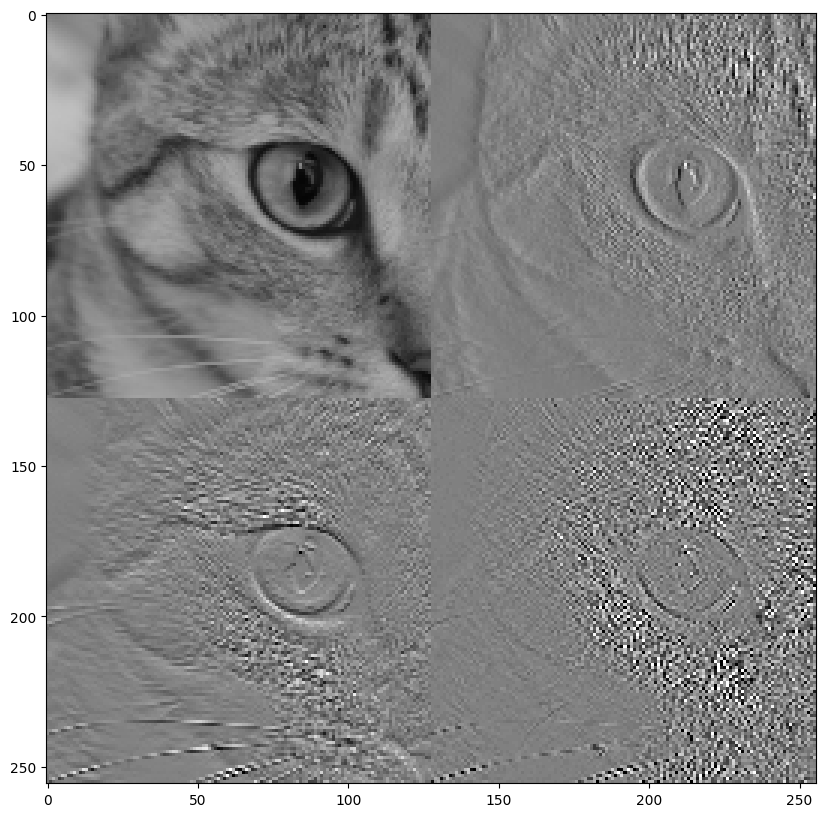

In [45]:
#1-level Haar Wavelet Transformation
haar = haar_wavelet(img,depth=1)

#Fix up transform for viewing
n = img.shape[0]
haar[n>>1:,n>>1:] *= 4
haar[n>>1:,:] += 0.5   #Note n>>1 = n/2
haar[:n>>1,n>>1:]+= 0.5
haar[:n>>1,:n>>1] /= 4

#Plot transform
plt.figure(figsize=(10,10))
plt.imshow(haar,cmap='gray',vmin=0,vmax=1)

##Wavelet Denoising

Wavelet-based image denoising is performed by reducing random noise by transforming the image into the wavelet domain, thresholding small high-frequency coefficients, and reconstructing a cleaner image.

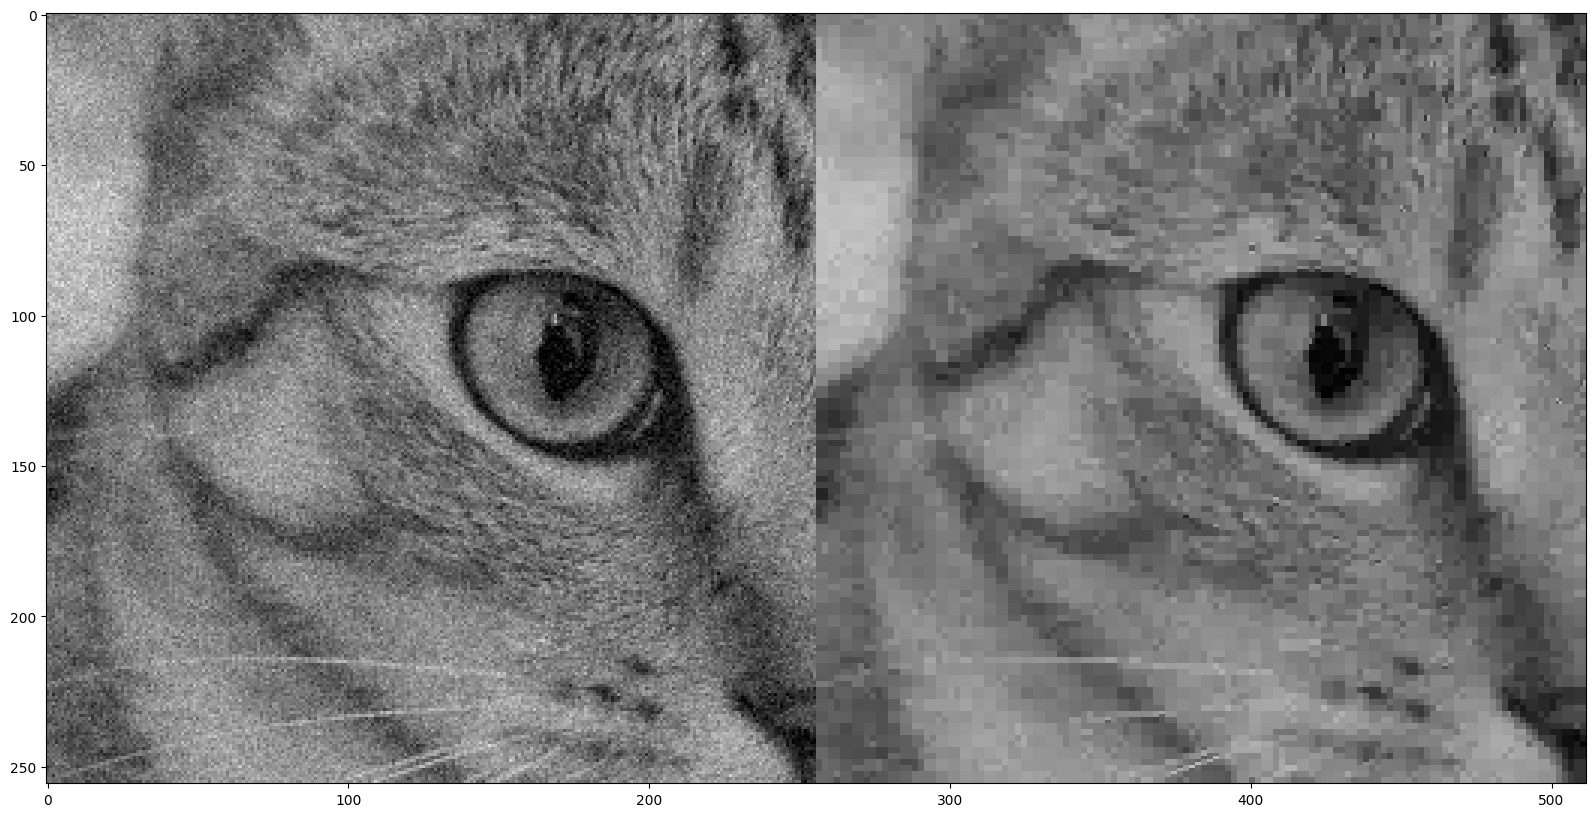

In [48]:
#Add noise to the image
img_noisy = img + 0.06*np.random.randn(n,n)

#Wavelet denoising
depth = 2
thresh = 0.5

#Wavelet transformation
wav = haar_wavelet(img_noisy,depth=depth)

#Threshold detail coefficients
wav_thresh = wav * (np.absolute(wav) > thresh)
wav_thresh[:n>>depth,:n>>depth] = wav[:n>>depth,:n>>depth]

#Inverse transform
img_denoised = inverse_haar_wavelet(wav_thresh,depth=depth)

#Plot results
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((img_noisy,img_denoised)),cmap='gray',vmin=0,vmax=1)

###Exercise
Experiment with the amount of noise, the depth of the transform (up to depth=9) and the tresholding value.

##Wavelet Compression

Image compression using the Haar wavelet transform keeps only the most significant wavelet coefficients (above a threshold) and discarding small ones that contribute little to visual quality.

By reconstructing the image from these retained coefficients, you get a compressed image that looks almost identical to the original but uses far fewer data points.

**Compression ratio** measures how much an image (or data) has been reduced in size after compression, compared to the original.

**Mean Squared Error** (MSE) measures the average squared difference between the original and reconstructed (or compressed/denoised) image.

**Peak Signal-to-Noise Ratio** (PSNR) expresses the ratio between the maximum possible signal power (pixel intensity) and the power of the noise (error), measured in decibels (dB). **A higher PSNR indicates better quality and less distortion.**

Compression ratio: 9.03:1
PSNR: 28.99 dB


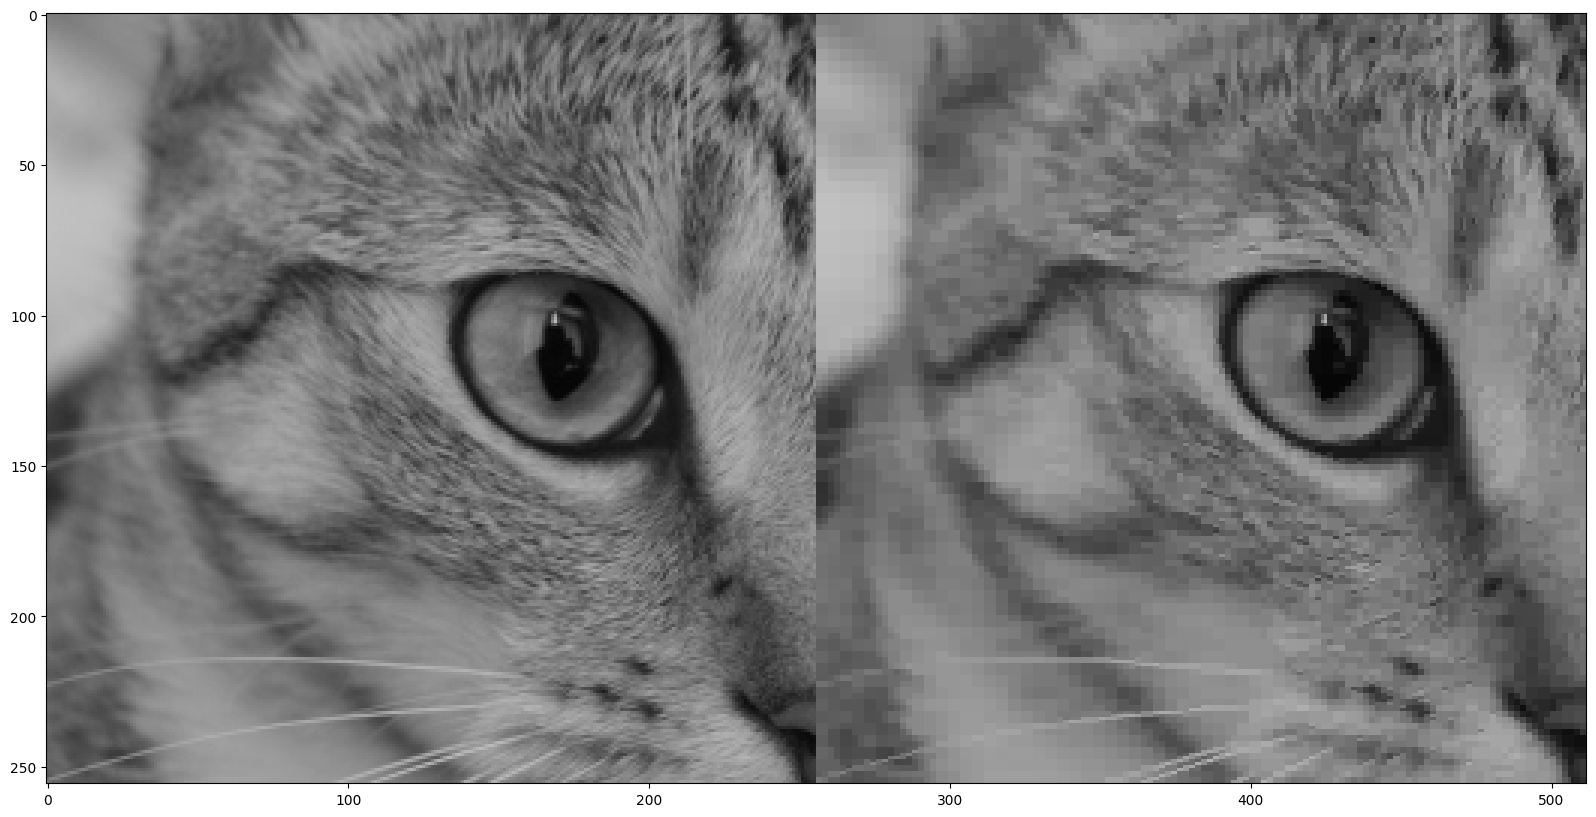

In [53]:
#Wavelet compression
depth = 3
thresh = 0.25

#Take Wavelet Transformation
wav = haar_wavelet(img, depth=depth)

#Threshold detail coefficients
wav_thresh = wav * (np.absolute(wav) > thresh)
wav_thresh[:n>>depth,:n>>depth] = wav[:n>>depth,:n>>depth]

#Take inverse transformation
img_comp = inverse_haar_wavelet(wav_thresh, depth=depth)

#Compute Compression ratio
frac_nonzero = np.sum(wav_thresh != 0.0) / wav_thresh.size
comp_ratio = 1/frac_nonzero
print("Compression ratio: %.2f:1"%comp_ratio)

#Compute Peak Signal to Noise Ratio (PSNR)
MSE = np.sum((img - img_comp)**2)/img.size
PSNR = 10*np.log10(np.max(img)**2/MSE)
print('PSNR: %.2f dB'%PSNR)

#Plot result
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((img,img_comp)),cmap='gray',vmin=0,vmax=1)

###Exercise
Experiment with the depth of the wavelet transformation and the threshold. What kind of artifacts to you see at very high compression ratios?

----